# Импорт библиотек 

In [621]:
import numpy as np 
import pandas as pd

In [622]:
import sys
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from bs4 import BeautifulSoup    
import requests 
import unicodedata
import re

In [623]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_regression, mutual_info_regression, mutual_info_classif, f_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from pandas import Series

from sklearn.metrics import recall_score
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.base import clone
import datetime
from datetime import datetime, timedelta
import math
from itertools import combinations
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from tqdm.notebook import tqdm
import xgboost as xgb
from catboost import CatBoostRegressor
from pprint import pprint

In [624]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [625]:
RANDOM_SEED = 42

In [626]:
#определим функцию для оценки модели
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [627]:
#определим функцию для обучения и предсказания
def learn_model_log(model):
    model.fit(X_train,np.log(y_train+1))
    y_pred = np.exp(model.predict(X_test))
    print (f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

# Парсинг

Для начала посмотрим тестовый датасет

In [628]:
data_test = pd.read_csv('data/test.csv')
data_sample = pd.read_csv('data/sample_submission.csv')

In [629]:
data_test.head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [630]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

##### в датасете 6 числовых признаков, остальные - категориальные. Рассмотим признаки в тестовом датасете чуть ближе

In [29]:
for col in data_test.columns:
    if col != 'complectation_dict':
        print(f'name of column: {col}','\n', data_test[col].value_counts()[:10], '\n')

name of column: bodyType 
 седан                   13147
внедорожник 5 дв.       12228
лифтбек                  2232
хэтчбек 5 дв.            2124
универсал 5 дв.          1276
минивэн                   995
купе                      824
компактвэн                489
хэтчбек 3 дв.             485
пикап двойная кабина      280
Name: bodyType, dtype: int64 

name of column: brand 
 BMW           4473
VOLKSWAGEN    4404
NISSAN        4393
MERCEDES      4180
TOYOTA        3913
AUDI          3421
MITSUBISHI    2843
SKODA         2741
VOLVO         1463
HONDA         1150
Name: brand, dtype: int64 

name of column: car_url 
 https://auto.ru/cars/used/sale/lexus/es/1101129190-bded86cb/              1
https://auto.ru/cars/used/sale/audi/100/1101030894-85d1dbe6/              1
https://auto.ru/cars/used/sale/lexus/lx/1101315885-8a3d242b/              1
https://auto.ru/cars/used/sale/mitsubishi/grandis/1099494886-3493e1e1/    1
https://auto.ru/cars/used/sale/lexus/lx/1101186740-34619e77/          

Для подготовки к парсингу создадим словарь brand_dict, где ключи - марки автомобилей, а значения - их кол-ва в test:

In [364]:
brands = data_test.brand.value_counts()
brand_dict = {brands.index[i]: brands[i] for i in range(len(brands))}
brand_dict

{'BMW': 4473,
 'VOLKSWAGEN': 4404,
 'NISSAN': 4393,
 'MERCEDES': 4180,
 'TOYOTA': 3913,
 'AUDI': 3421,
 'MITSUBISHI': 2843,
 'SKODA': 2741,
 'VOLVO': 1463,
 'HONDA': 1150,
 'INFINITI': 871,
 'LEXUS': 834}

In [13]:
brands = list(brand_dict.keys())

# Парсинг данных для тренировочного датасета:  
 Возьмем только бренды, которые представлены в тестовом датасете

In [14]:
'''cars_urls = {}
url = 'https://auto.ru/cars/'
header = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:32.0) Gecko/20100101 Firefox/32.0',}
for car_brand in brands:
    brand_url = url + car_brand + '/used/?page='
    cars_urls[car_brand] = []
    print(car_brand)
    for number in range(1, 100):
        response = requests.get(brand_url+str(number), headers=header)
        page = BeautifulSoup(response.text, 'html.parser')
        link_list = page.find_all('a', class_='Link ListingItemTitle__link')
        if len(link_list) !=0:
            for link in link_list:
                cars_urls[car_brand].append(link['href'])
        else:
            break
with open('data.json', 'w') as fp:
    json.dump(cars_urls, fp)
    
brands = []
cars_urls = []

for brand in data.keys():
    for url in data[brand]:
        brands.append(brand)
        cars_urls.append(url)

counter = 0
final_dict={}
final_dict['car'] = []

for url in cars_urls:
    url_dict = {}
    response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    response.encoding = 'utf-8'
    page = BeautifulSoup(response.text, 'html.parser')
    if 'Этот автомобиль уже продан' in page.text:
        continue
    else:
        try:
            first_dict = ast.literal_eval(str(page.find_all('script', attrs = {'type':'application/ld+json'})[0])[35:-9])
        except IndexError:
            continue
        url2 = ast.literal_eval(str(page.find_all('script', attrs = {'type':'application/ld+json'})[0])[35:-9])['offers']['url']
        if url != url2:
            continue
        else:
            try:
                url_dict['bodyType'] = first_dict['bodyType']
                url_dict['brand'] = first_dict['brand']
                url_dict['car_url'] = url
                url_dict['color'] = first_dict['color']
                url_dict['description'] = first_dict['description']
                url_dict['engineDisplacement'] = first_dict['vehicleEngine']['engineDisplacement']
                url_dict['enginePower'] = first_dict['vehicleEngine']['enginePower']
                url_dict['fuelType'] = first_dict['vehicleEngine']['fuelType']
                url_dict['mileage'] = int(page.find('li', class_ = 'CardInfoRow CardInfoRow_kmAge').find_all('span', class_='CardInfoRow__cell')[1].text.replace(u'\xa0', u' ')[:-3].replace(' ', ''))
                url_dict['modelDate'] = first_dict['modelDate']
                url_dict['model_name'] = str(page.find('script', attrs = {'type':'application/json', 'id':'initial-state'})).partition('"model_info":{"code":"')[2].partition('","name":"')[0]
                url_dict['name'] = str(page.find('script', attrs = {'type':'application/json', 'id':'initial-state'})).partition('"tech_param":')[2].partition('"human_name":"')[2].partition(')')[0]+')'
                url_dict['numberOfDoors'] = first_dict['numberOfDoors']
                url_dict['productionDate'] = first_dict['productionDate']
                url_dict['numberOfDoors'] = first_dict['numberOfDoors']
                url_dict['vehicleConfiguration'] = first_dict['vehicleConfiguration']
                url_dict['vehicleTransmission'] = first_dict['vehicleTransmission']
                url_dict['Владельцы'] = page.find('li', class_ = 'CardInfoRow CardInfoRow_ownersCount').find_all('span', class_='CardInfoRow__cell')[1].text.replace(u'\xa0', u' ')
                url_dict['ПТС'] = page.find('li', class_ = 'CardInfoRow CardInfoRow_pts').find_all('span', class_='CardInfoRow__cell')[1].text
                url_dict['Привод'] = page.find('li', class_ = 'CardInfoRow CardInfoRow_drive').find_all('span', class_='CardInfoRow__cell')[1].text
                url_dict['Руль'] = page.find('li', class_ = 'CardInfoRow CardInfoRow_wheel').find_all('span', class_='CardInfoRow__cell')[1].text
                complectation = []
                for i in page.find_all('li', class_='ComplectationGroups__itemContentEl'):
                    complectation.append(i.text)
                url_dict['complectation'] = complectation
                super_gen = page.find('a', class_='Link SpoilerLink CardCatalogLink SpoilerLink_type_default')['href']
                response_1 = requests.get(super_gen, headers={'User-Agent': 'Mozilla/5.0'})
                response_1.encoding = 'utf-8'
                page_1 = BeautifulSoup(response_1.text, 'html.parser')
                for i in page_1.find_all('dd', class_='list-values__value'):
                    if ' с' in i.text:
                        url_dict['acceleration'] = i.text[:-2]
                url_dict.setdefault('acceleration', np.nan)
                ls = []
                for i in page_1.find_all('dd', class_='list-values__value'):
                    if ' л' in i.text:
                        ls.append(i.text)
                    if len(ls) == 3:
                        url_dict['fuel_rate'] = ls[2][:-2]
                url_dict.setdefault('fuel_rate', np.nan)
                url_dict['Price'] = int(page.find('span', class_ = 'OfferPriceCaption__price').text.replace(u'\xa0', u' ')[:-2].replace(' ', ''))
                final_dict['car'].append(url_dict)
                counter+=1
                if counter%100 == 0:
                    print(counter)
            except (KeyError, ValueError, AttributeError) as e:
                continue
print('end')
'''

'cars_urls = {}\nurl = \'https://auto.ru/cars/\'\nheader = {\'user-agent\': \'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:32.0) Gecko/20100101 Firefox/32.0\',}\nfor car_brand in brands:\n    brand_url = url + car_brand + \'/used/?page=\'\n    cars_urls[car_brand] = []\n    print(car_brand)\n    for number in range(1, 100):\n        response = requests.get(brand_url+str(number), headers=header)\n        page = BeautifulSoup(response.text, \'html.parser\')\n        link_list = page.find_all(\'a\', class_=\'Link ListingItemTitle__link\')\n        if len(link_list) !=0:\n            for link in link_list:\n                cars_urls[car_brand].append(link[\'href\'])\n        else:\n            break\nwith open(\'data.json\', \'w\') as fp:\n    json.dump(cars_urls, fp)\n    \nbrands = []\ncars_urls = []\n\nfor brand in data.keys():\n    for url in data[brand]:\n        brands.append(brand)\n        cars_urls.append(url)\n\ncounter = 0\nfinal_dict={}\nfinal_dict[\'car\'] = []\n\nfor url i

In [631]:
#загрузим датасет
data_train = pd.read_csv('data/train.csv')

C:\Users\babaina_mv\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (27,36) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Предобработка данных.

In [632]:
data_train.shape

(125116, 37)

In [633]:
#Удалим дубликаты и пустые строки из тренировочных данных
data_train = data_train.drop_duplicates(subset=['sell_id'])
data_train = data_train.dropna(how='all')
len(data_train)

87105

In [634]:
#приведем test & train к единообразному виду
#сначала сравниваем наличие тех или иных колонок в двух датасетах
in_test = []
not_in_test = []

for column in data_train.columns:
    if column in data_test.columns:
        in_test.append(column)
    else:
        not_in_test.append(column)

In [635]:
#Посмотрим на колонки data_train, отсутствующие в data_test
not_in_test

['Unnamed: 0',
 'datetime',
 'card',
 'region',
 'sellerName',
 'price',
 'engine',
 'public_date',
 'nview',
 'model_name_full',
 'confDict',
 'card_type',
 'model_name2',
 'dealerName']

In [636]:
#Удалим из data_train колонки, отсутствующие в data_test, кроме price
columns_drop = not_in_test[:5] + not_in_test[6:]

In [637]:
data_train = data_train.drop(columns_drop, axis = 1)
data_train.head()

,parsing_unixtime,sell_id,car_url,price,description,image,bodyType,color,engineDisplacement,enginePower,...,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,equipment_dict,brand,model_name,name
0,1.618530e+09,№ 1099731144,https://auto.ru/cars/used/sale/honda/mobilio/1...,280 000 ₽,"Все интересующие вопросы по телефону, дефекты ...",https://avatars.mds.yandex.net/get-verba/78701...,компактвэн,серый,1.5 л,110 л.с.,...,3 или более,Оригинал,передний,Правый,Не требует ремонта,Растаможен,"{'asciiCat': 'cars', 'category': 'cars', 'engi...",Honda,Mobilio,1.5 CVT (110 л.с.)
1,1.618530e+09,№ 1098465088,https://auto.ru/cars/used/sale/honda/civic/109...,230 000 ₽,Автомобиль в хорошем состаянии.требуется покра...,https://avatars.mds.yandex.net/get-autoru-vos/...,седан,белый,1.5 л,105 л.с.,...,3 или более,Оригинал,передний,Правый,Не требует ремонта,Растаможен,"{'asciiCat': 'cars', 'category': 'cars', 'engi...",Honda,Civic,1.5 AT (105 л.с.)
2,1.618530e+09,№ 1102645098,https://auto.ru/cars/used/sale/honda/civic/110...,210 000 ₽,Японец стильный мощный молодежный))Авто не нов...,https://avatars.mds.yandex.net/get-autoru-vos/...,седан,серебристый,1.6 л,110 л.с.,...,3 или более,Оригинал,передний,Правый,Не требует ремонта,Растаможен,"{'asciiCat': 'cars', 'category': 'cars', 'engi...",Honda,Civic,1.6 AT (110 л.с.)
3,1.618530e+09,№ 1098794368,https://auto.ru/cars/used/sale/honda/accord/10...,513 000 ₽,"Шикарный автомобиль, сел и поехал!!! Обслужива...",https://avatars.mds.yandex.net/get-verba/93714...,седан,белый,2.0 л,155 л.с.,...,1 владелец,Оригинал,передний,Правый,Не требует ремонта,Растаможен,"{'asciiCat': 'cars', 'category': 'cars', 'engi...",Honda,Accord,2.0 AT (155 л.с.)
4,1.618530e+09,№ 1098001866,https://auto.ru/cars/used/sale/honda/fit/10980...,230 000 ₽,"Продам автомобиль, хорошее тех. состояние. ПТС...",https://avatars.mds.yandex.net/get-verba/78701...,хэтчбек 5 дв.,белый,1.5 л,110 л.с.,...,3 или более,Оригинал,передний,Правый,Не требует ремонта,Растаможен,"{'asciiCat': 'cars', 'category': 'cars', 'engi...",Honda,Fit,1.5 AT (110 л.с.)


In [638]:
#Перезапишем data_test с теми колонками, которые есть и в data_train, и в data_test
data_test = data_test[in_test]
data_test.head()

,parsing_unixtime,sell_id,car_url,description,image,bodyType,color,engineDisplacement,enginePower,fuelType,...,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,equipment_dict,brand,model_name,name
0,1603226273,1100575026,https://auto.ru/cars/used/sale/skoda/octavia/1...,"Все автомобили, представленные в продаже, прох...",https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,лифтбек,синий,1.2 LTR,105 N12,бензин,...,3 или более,Оригинал,передний,Левый,Не требует ремонта,Растаможен,"{""engine-proof"":true,""tinted-glass"":true,""airb...",SKODA,OCTAVIA,1.2 AMT (105 л.с.)
1,1603226277,1100549428,https://auto.ru/cars/used/sale/skoda/octavia/1...,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,лифтбек,чёрный,1.6 LTR,110 N12,бензин,...,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",SKODA,OCTAVIA,1.6 MT (110 л.с.)
2,1603226280,1100658222,https://auto.ru/cars/used/sale/skoda/superb/11...,"Все автомобили, представленные в продаже, прох...",https://avatars.mds.yandex.net/get-autoru-vos/...,лифтбек,серый,1.8 LTR,152 N12,бензин,...,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,"{""cruise-control"":true,""tinted-glass"":true,""es...",SKODA,SUPERB,DSG 1.8 AMT (152 л.с.)
3,1603226284,1100937408,https://auto.ru/cars/used/sale/skoda/octavia/1...,КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,лифтбек,коричневый,1.6 LTR,110 N12,бензин,...,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,"{""cruise-control"":true,""roller-blind-for-rear-...",SKODA,OCTAVIA,1.6 AT (110 л.с.)
4,1603226288,1101037972,https://auto.ru/cars/used/sale/skoda/octavia/1...,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,лифтбек,белый,1.8 LTR,152 N12,бензин,...,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",SKODA,OCTAVIA,1.8 AT (152 л.с.)


In [639]:
data_train = data_train[data_train['price'] !='nan']

In [640]:
#приведем целевую переменную к числовому типу
data_train['price'] = data_train.price.apply(lambda x: unicodedata.normalize("NFKD",str(x)))

In [641]:
data_train['price'] = data_train.price.apply(lambda x: x.replace(' ₽',''))
data_train['price'] = data_train.price.apply(lambda x: x.replace(' ',''))

In [642]:
data_train = data_train[data_train['price'] !='nan']

In [643]:
data_train['price'] = data_train['price'].astype(int)

In [644]:
#объединяем трейн и тест, для учета всех возможных значений. Помечаем где у нас трейн
data_train['sample_'] = 0
data_test['sample_'] = 1
data_full = pd.concat([data_test, data_train])
data_full = data_full.reset_index().drop(['index'], axis = 1)

In [645]:
data_full = data_full[['parsing_unixtime', 'sell_id', 'car_url', 'description',
       'image', 'bodyType', 'color', 'engineDisplacement', 'enginePower',
       'fuelType', 'mileage', 'productionDate', 'vehicleTransmission',
       'Владельцы', 'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня',
       'equipment_dict', 'brand', 'model_name', 'name', 'sample_', 'price']]

In [646]:
#Удаляем дубликаты по ссылкам
data_full = data_full.drop_duplicates(subset=['car_url'])
len(data_full)

119870

In [647]:
#провверим на дубликаты по id, для этого приведем id в единый вид
data_full['sell_id'] = data_full.sell_id.apply(lambda x: int(str(x).replace('№ ','')))
data_full['sell_id'].value_counts()

1100086706    2
1094975488    1
1101952667    1
1102780087    1
1103040180    1
             ..
1100487080    1
1101816231    1
1103128998    1
1103034948    1
1102802100    1
Name: sell_id, Length: 119869, dtype: int64

In [648]:
#оставим по одному объявлению на id
data_full = data_full.drop_duplicates(subset=['sell_id'])
len(data_full)

119869

# EDA

In [649]:
data_full.sample(3)

,parsing_unixtime,sell_id,car_url,description,image,bodyType,color,engineDisplacement,enginePower,fuelType,...,Привод,Руль,Состояние,Таможня,equipment_dict,brand,model_name,name,sample_,price
118662,1.618585e+09,1103205080,https://auto.ru/cars/used/sale/mitsubishi/l200...,Состояние сел и поехал! Родной ПТС! Месяц наза...,https://avatars.mds.yandex.net/get-verba/78701...,пикап двойная кабина,чёрный,2.5 л,136 л.с.,Дизель,...,полный,Левый,Не требует ремонта,Растаможен,"{'asciiCat': 'cars', 'category': 'cars', 'engi...",Mitsubishi,L200,2.5d MT (136 л.с.) 4WD,0,498000.0
111072,1.618582e+09,1099037058,https://auto.ru/cars/used/sale/skoda/rapid/109...,отличное состояние- стоит новая резина- подогр...,https://avatars.mds.yandex.net/get-verba/78701...,лифтбек,белый,1.6 л,105 л.с.,Бензин,...,передний,Левый,Не требует ремонта,Растаможен,"{'asciiCat': 'cars', 'category': 'cars', 'engi...",Skoda,Rapid,1.6 MT (105 л.с.),0,555000.0
63876,1.618567e+09,1098559036,https://auto.ru/cars/used/sale/bmw/3er/1098559...,"Пишите, все расскажу.",https://avatars.mds.yandex.net/get-verba/78701...,седан,чёрный,1.8 л,115 л.с.,Бензин,...,задний,Левый,Не требует ремонта,Растаможен,"{'asciiCat': 'cars', 'category': 'cars', 'engi...",BMW,3 серии,N42 316i 1.8 AT (115 л.с.),0,360000.0


In [650]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119869 entries, 0 to 121789
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   parsing_unixtime     119869 non-null  float64
 1   sell_id              119869 non-null  int64  
 2   car_url              119869 non-null  object 
 3   description          119337 non-null  object 
 4   image                119869 non-null  object 
 5   bodyType             119869 non-null  object 
 6   color                119869 non-null  object 
 7   engineDisplacement   119869 non-null  object 
 8   enginePower          119869 non-null  object 
 9   fuelType             119869 non-null  object 
 10  mileage              119869 non-null  object 
 11  productionDate       119869 non-null  float64
 12  vehicleTransmission  119869 non-null  object 
 13  Владельцы            119869 non-null  object 
 14  ПТС                  119868 non-null  object 
 15  Привод           

Мы видим 23 признака('sample' не считаем), из них 3 - числовых, остальные - категориальные. Также в дальнейшем анализе опустим parsing_unixtime, sell_id, car_url, description, image, таможня, equipment_dict, name -  то есть оставим 15 признаков  
Сразу заметим, что два категориальных признака - 'enginePower' и 'engineDisplacement' по сути являются числовыми, принимая значения в своих числовых диапазонах. Поэтому уже на этапе анализа сделаем эти признаки числовыми.

In [651]:
# Количество уникальных значений в этих признаках достаточно большое
print(data_full['enginePower'].nunique(), data_full['engineDisplacement'].nunique())

632 107


In [652]:
# Избавимся от пропусков в Engine Displacement, заменив на среднее
data_full['engineDisplacement'] = data_full['engineDisplacement'].apply(lambda x: '2.5 LTR' if x == ' LTR' else x)
data_full['engineDisplacement'] = data_full['engineDisplacement'].apply(lambda x: x.replace('л ','LTR'))

In [653]:
#теперь приведем к числовому формату
data_full['engineDisplacement'] = data_full['engineDisplacement'].apply(
                                                    lambda x: int(x.split(' ')[0].replace('.', '')))

In [654]:
data_full['enginePower'] = data_full['enginePower'].apply(lambda x: x.replace('\xa0л.с. ','N12'))

In [655]:
data_full['enginePower'] = data_full['enginePower'].apply(lambda x: x.replace(' ',''))

In [656]:
data_full['enginePower'] = data_full['enginePower'].apply(lambda x: int(x.split('N')[0].replace('.', '')))

In [657]:
data_full['mileage'] = data_full['mileage'].apply(lambda x: str(x).replace('\xa0', ''))

In [658]:
#Преобразуем признак из object в числовой.
pattern = re.compile('\d+')

data_full['mileage'] = data_full['mileage'].apply(lambda x: int(pattern.findall(x)[0]))

# Категориальные признаки

In [659]:
#Теперь займемся категориальными признаками
data_full['Владельцы'].value_counts()

3 или более    56618
1 владелец     32924
2 владельца    30327
Name: Владельцы, dtype: int64

In [660]:
#Проверим признак на пустые ячейки и уникальные значения
data_full.productionDate.isna().sum()

0

In [661]:
data_full['Владельцы'].unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца'], dtype=object)

In [662]:
#Преобразуем данные к презентабельному виду - заменим части строки равные '\xa0' на ' ' во всех значениях признака
data_full['Владельцы'] = data_full['Владельцы'].apply(lambda x: str(x).replace('\xa0', ' '))

<AxesSubplot:>

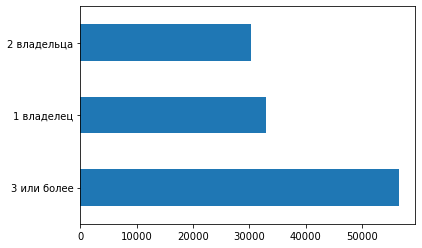

In [663]:
data_full['Владельцы'].value_counts().plot.barh()

In [664]:
#BodyType - посмотрим на уникальные значения
data_full['bodyType'].value_counts()

внедорожник 5 дв.          45920
седан                      42821
хэтчбек 5 дв.               8360
лифтбек                     7951
универсал 5 дв.             4331
минивэн                     2759
купе                        2149
компактвэн                  2028
пикап двойная кабина        1019
хэтчбек 3 дв.                944
купе-хардтоп                 515
внедорожник 3 дв.            366
родстер                      201
кабриолет                    177
фургон                       176
микровэн                      86
пикап полуторная кабина       20
седан-хардтоп                 12
пикап одинарная кабина        12
лимузин                        7
внедорожник открытый           6
седан 2 дв.                    6
тарга                          2
фастбек                        1
Name: bodyType, dtype: int64

In [665]:
#некоторых видов не так много, и некоторые значения однотипные. Попробуем их немного сгруппировать в более общие типы
def get_bodyClass(bodyType):
    
    bodyClass = 'other'
    
    dict_bodyTypes = {'седан' : ['седан', 'седан-хардтоп', 'фастбек'],
                          'внедорожник' : ['внедорожник 5 дв.', 'внедорожник 3 дв.', 'внедорожник открытый'],
                          'хэтчбек': ['хэтчбек 5 дв.', 'хэтчбек 4 дв.', 'хэтчбек 3 дв.'],
                          'универсал': ['универсал 5 дв.'],
                          'лифтбек': ['лифтбек'],
                          'автобус': ['микровэн', 'минивэн', 'компактвэн'],                      
                          'грузо-пассажирский': ['пикап полуторная кабина', 'пикап одинарная кабина', 'пикап двойная кабина', 'фургон']
                          #,'купе': ['купе', 'купе-хардтоп', 'седан 2 дв.'],
                          #,'открытый/съемный верх': ['кабриолет', 'фаэтон', 'тарга', 'родстер']
                     }
    
    for key, value in dict_bodyTypes.items():   
        if bodyType in value:
            bodyClass = key
            break
    
    return bodyClass

data_full['bodyClass'] = data_full.bodyType.apply(lambda x: get_bodyClass(x))
data_full.bodyClass.value_counts()

внедорожник           46292
седан                 42834
хэтчбек                9304
лифтбек                7951
автобус                4873
универсал              4331
other                  3057
грузо-пассажирский     1227
Name: bodyClass, dtype: int64

In [666]:
#посмотрим на признак color
data_full['color'].value_counts()

чёрный         36714
белый          24883
серый          15426
серебристый    14963
синий           9372
красный         4942
коричневый      4664
зелёный         2272
бежевый         1913
голубой         1538
золотистый       939
пурпурный        712
фиолетовый       653
оранжевый        404
жёлтый           400
розовый           74
Name: color, dtype: int64

In [667]:
#пропусков нет, оставим признак в таком виде

In [668]:
#посмторим на признак fuelType
data_full.fuelType.value_counts()

 Бензин                                68956
бензин                                 28601
 Дизель                                13353
дизель                                  5800
 Гибрид                                 1665
 Бензин, газобаллонное оборудование     1200
гибрид                                   223
электро                                   55
газ                                        7
 Гибрид, газобаллонное оборудование        4
 Дизель, газобаллонное оборудование        4
 Газ, газобаллонное оборудование           1
Name: fuelType, dtype: int64

In [669]:
#пропусков нет, приведем к единообразному виду, сократим количество видов топлива
data_full.fuelType = data_full.fuelType.apply(lambda x: 'газ' if x == ' Газ, газобаллонное оборудование' else x)
data_full = data_full.drop(data_full[data_full.fuelType == '1618546594.0'].index)
data_full.fuelType = data_full.fuelType.apply(lambda x: x.lower())

pattern = re.compile('[а-я]+')
data_full.fuelType = data_full.fuelType.apply(lambda x: 'гибрид' if len(x.split(',')) == 2 else pattern.findall(x)[0])

In [670]:
data_full.fuelType.value_counts()

бензин     97557
дизель     19153
гибрид      3096
электро       55
газ            8
Name: fuelType, dtype: int64

<AxesSubplot:>

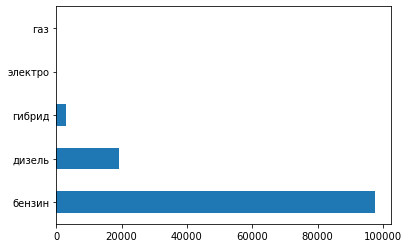

In [671]:
data_full.fuelType.value_counts().plot.barh()

In [672]:
#vehicleTransmission
data_full.vehicleTransmission.value_counts()

автоматическая      69243
механическая        21163
вариатор            18479
роботизированная    10984
Name: vehicleTransmission, dtype: int64

<AxesSubplot:>

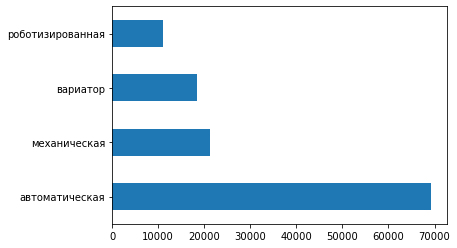

In [673]:
data_full['vehicleTransmission'].value_counts().plot.barh()

In [674]:
#оставим признак без изменений

In [675]:
#посмотрим и обработаем признак Владельцы
data_full['Владельцы'].value_counts()

3 или более    56618
1 владелец     32924
2 владельца    30327
Name: Владельцы, dtype: int64

In [676]:
data_full['Владельцы'] = data_full['Владельцы'].apply(lambda x: str(x).replace('\xa0', ' '))

In [677]:
data_full['Владельцы'].unique()

array(['3 или более', '1 владелец', '2 владельца'], dtype=object)

<AxesSubplot:>

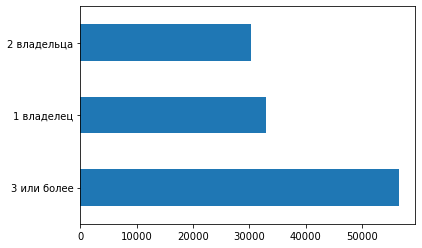

In [678]:
data_full['Владельцы'].value_counts().plot.barh()

In [679]:
#ПТС
data_full['ПТС'].isna().sum()

1

In [680]:
#Заменим пропуск наиболее частым значением
data_full['ПТС'] = data_full['ПТС'].fillna(data_full['ПТС'].value_counts().head(1).index[0])

<AxesSubplot:xlabel='ПТС', ylabel='count'>

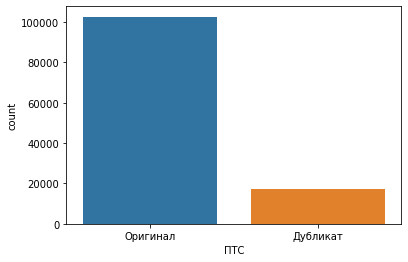

In [681]:
sns.countplot(x = 'ПТС', data = data_full)

In [682]:
#Привод
data_full['Привод'].value_counts()

передний    53614
полный      52792
задний      13463
Name: Привод, dtype: int64

In [683]:
data_full.Привод.isna().sum()

0

<AxesSubplot:xlabel='Привод', ylabel='count'>

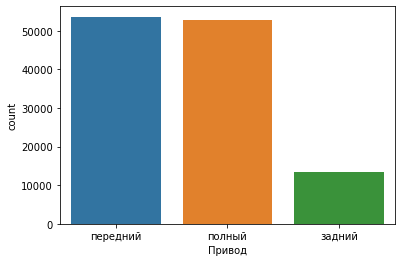

In [684]:
sns.countplot(x='Привод', data=data_full)

Дополнительная обработка не требуется

In [685]:
#Руль
data_full['Руль'].value_counts()

Левый     108449
Правый     11420
Name: Руль, dtype: int64

In [686]:
data_full.Руль.isna().sum()

0

<AxesSubplot:xlabel='Руль', ylabel='count'>

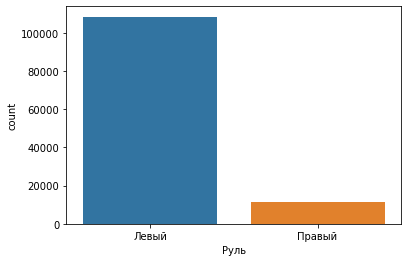

In [687]:
sns.countplot(x='Руль', data=data_full)

Дополнительная обработка не требуется

In [688]:
#состояние
data_full['Состояние'].value_counts()

Не требует ремонта    119867
Битый / не на ходу         2
Name: Состояние, dtype: int64

In [689]:
data_full.Состояние.isna().sum()

0

<AxesSubplot:xlabel='Состояние', ylabel='count'>

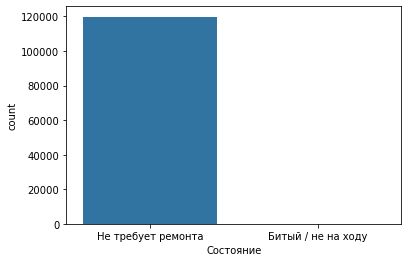

In [690]:
sns.countplot(x='Состояние', data=data_full)

In [691]:
#brand
data_full['brand'].value_counts()

Toyota           16130
BMW              15307
Nissan           13279
Mercedes-Benz    11300
Skoda             7304
Mitsubishi        7078
Audi              6429
Honda             5465
VOLKSWAGEN        4404
NISSAN            4393
MERCEDES          4180
TOYOTA            3913
AUDI              3421
Lexus             3214
MITSUBISHI        2843
SKODA             2741
Volvo             2502
Infiniti          1648
VOLVO             1463
HONDA             1150
INFINITI           871
LEXUS              834
Name: brand, dtype: int64

In [692]:
#Приведем названия к единому формату
data_full['brand'] = data_full['brand'].apply(lambda x: x.lower())
data_full['brand'] = data_full['brand'].apply(
    lambda x: x.replace('mercedes-benz', 'mercedes'))

In [693]:
data_full['brand'].value_counts()

toyota        20043
nissan        17672
mercedes      15480
bmw           15307
skoda         10045
mitsubishi     9921
audi           9850
honda          6615
volkswagen     4404
lexus          4048
volvo          3965
infiniti       2519
Name: brand, dtype: int64

Оставим так

In [694]:
#обработаем схожим образом model_name
data_full['model_name'].value_counts()

Octavia     3395
Camry       3071
X5          2570
E-Класс     2344
A6          2261
            ... 
MINICA         1
X4 M           1
GS F           1
02             1
CAVALIER       1
Name: model_name, Length: 958, dtype: int64

In [695]:
data_full['model_name'] = data_full['model_name'].apply(
    lambda x: x.lower().strip())
data_full['model_name'].value_counts()

octavia            4813
camry              3780
lancer             3062
qashqai            2753
corolla            2675
                   ... 
z1                    1
urban cruiser         1
terrano_regulus       1
favorit               1
280zx                 1
Name: model_name, Length: 761, dtype: int64

In [696]:
# Списки числовых и категориальных признаков в data_full
num_f = ['productionDate', 'mileage', 'enginePower', 'engineDisplacement']
 
cat_f = ['bodyType', 'brand', 'color', 'fuelType', 'model_name', 'Привод', 'Руль',
         'vehicleTransmission', 'Владельцы', 'ПТС', 'Состояние']

In [697]:
#оставим в датасете только нужные обработанные признаки
data_full = data_full[num_f + cat_f + ['price', 'sample_']]

Числовые признаки - посмотрим их чуть подробнее

C:\Users\babaina_mv\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


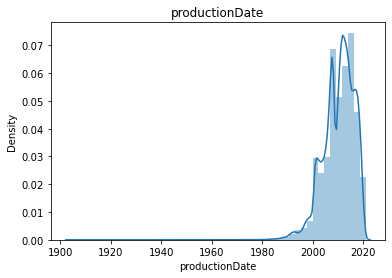

C:\Users\babaina_mv\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


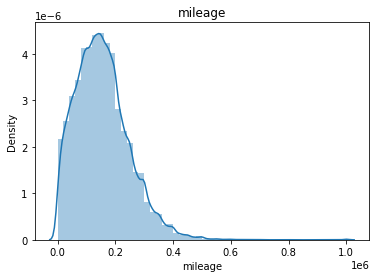

C:\Users\babaina_mv\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


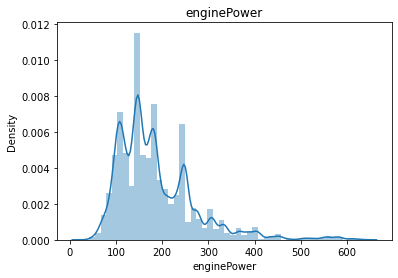

C:\Users\babaina_mv\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


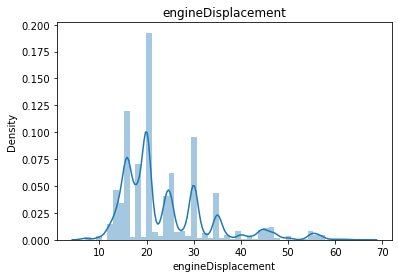

In [698]:
for i in num_f:
    plt.figure()
    sns.distplot(data_full[i])
    plt.title(i)
    plt.show()

Видим, что распределения у признаков близки к нормальным, справа или слева имеются длинные хвосты.  
Посмотрим на выбросы

<AxesSubplot:>

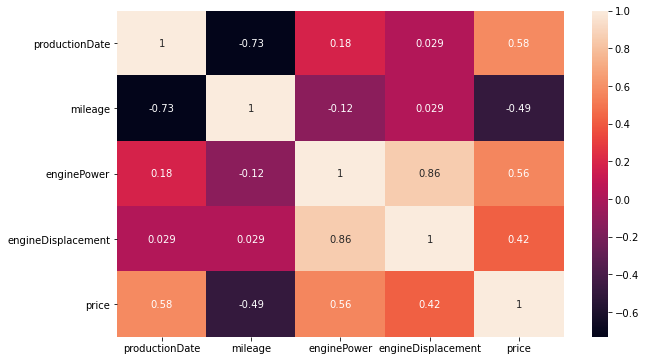

In [699]:
# Посмотрим корреляцию числовых признаков
plt.figure(figsize=(10, 6))
sns.heatmap(data_full[data_full['sample_'] == 0][num_f + ['price']].corr(), annot=True)

Выводы по рассмотрению корреляции числовых признаков:  
  +0.86 между мощностью и объемом двигателя  
  -0.73 между пробегом и годом производства, пока оставим. Можно создать новый признак пробег/возраст
  
  Удаляем один признак - engineDisplacement

In [700]:
data_full = data_full.drop(['engineDisplacement'], axis = 1)
num_f = ['productionDate', 'mileage', 'enginePower']

# Feature Engineering

Создадим два бинарных категориальных признака, которые могут повлиять на стоимость автомобиля:  
'allroad' - будет отражать наличие полного привода  
'luxury' - будет отражать премиальность бренда

In [701]:
data_full['luxury'] = data_full['brand'].apply(lambda x: 1 if x in ['BMW','MERCEDES','LEXUS','INFINITI'] else 0)
cat_f.append('luxury')

In [702]:
data_full['allroad'] = data_full['Привод'].apply(lambda x: 1 if x.split('_')[0] == 'полный' else 0)
cat_f.append('allroad')

Создадим полиномиальные новые признаки на основе двух числовых 'productionDate' и 'enginePower' и нормируем их

pf = PolynomialFeatures(3)
poly_features = pf.fit_transform(data_full[[ 'productionDate', 'enginePower']])
poly = pd.DataFrame(poly_features).drop([0,1,2,3,4,6,8], axis = 1)
poly.columns = ['date_power5', 'date_power7', 'date_power9']

for col in list(poly.columns):
    col_max = poly[col].max()    
    poly[col] = poly[col].apply(lambda x: int(round(x/col_max*100000, 0)))
    
data_full = pd.concat([data_full, poly], axis=1)
num_f = num_f + list(poly.columns)

<AxesSubplot:>

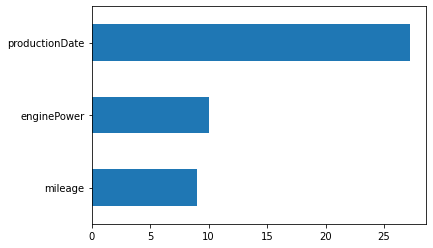

In [703]:
#Оценим значимость числовых переменных
imp_num = Series(f_classif(data_full[num_f][data_full['sample_'] == 0], data_full[data_full['sample_'] == 0]['price'])[0], 
                 index = num_f)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

наиболее важный признак для предсказания - это productionDate, а наименее - mileage

In [704]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119869 entries, 0 to 121789
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   productionDate       119869 non-null  float64
 1   mileage              119869 non-null  int64  
 2   enginePower          119869 non-null  int64  
 3   bodyType             119869 non-null  object 
 4   brand                119869 non-null  object 
 5   color                119869 non-null  object 
 6   fuelType             119869 non-null  object 
 7   model_name           119869 non-null  object 
 8   Привод               119869 non-null  object 
 9   Руль                 119869 non-null  object 
 10  vehicleTransmission  119869 non-null  object 
 11  Владельцы            119869 non-null  object 
 12  ПТС                  119869 non-null  object 
 13  Состояние            119869 non-null  object 
 14  price                85183 non-null   float64
 15  sample_          

# 5. Label Encoding

In [705]:
# Кодируем категориальные признаки
label_encoder = LabelEncoder()
for column in cat_f:
    data_full[column] = label_encoder.fit_transform(data_full[column])

<AxesSubplot:>

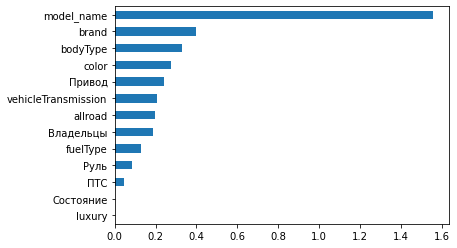

In [706]:
#Посмотрим значимость
imp_cat = Series(mutual_info_classif(data_full[data_full.sample_ == 0][cat_f], data_full[data_full.sample_ == 0]['price'],
                                     discrete_features =True), index = cat_f)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Самым значимым признаком оказался model_name, наименее - Состояние и luxury

In [707]:
#сделаем копию датасета
df = data_full.copy()

In [708]:
#Произведем Label-encoding категориальных переменных
label_encoder = LabelEncoder()
for column in cat_f:
    df[column] = label_encoder.fit_transform(df[column])

Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределения цены по различным параметрам неразличимы

In [594]:
def get_stat_dif(column):
    cols = df.loc[:, column].value_counts()
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if stats.ttest_ind(df.loc[df.loc[:, column] == comb[0], 'price'], 
                        df.loc[df.loc[:, column] == comb[1], 'price']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break
            
for col in cat_f:
    get_stat_dif(col)

C:\Users\babaina_mv\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\babaina_mv\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\babaina_mv\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\babaina_mv\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\babaina_mv\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


C:\Users\babaina_mv\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\babaina_mv\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\babaina_mv\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\babaina_mv\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\babaina_mv\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Найдены статистически значимые различия для колонки model_name


In [709]:
#Так как число уникальных значений для поля model_name очень большое не включаем его в модель
cat_f.remove('model_name')
data_full.drop(columns=['model_name'], inplace=True)

In [710]:
#Создадим дамми переменные
data_full = pd.get_dummies(data_full, columns = cat_f)

In [711]:
first_index_cat_f = data_full.columns.to_list().index('sample_')+1
cat_f = data_full.columns[first_index_cat_f:].to_list()

Выводы
Спарсилось очень много дублей. Спарсенные данные не везде совпадают с тестовым датасетом, пришлось делать дополнительную обработку. В данных очень много категориальных признаков. Некоторые признаки несбалансированы.

# Обучение и моделирование

In [714]:
#Сначала выделим тестовую и тренировочную части.
data_train = data_full[data_full.sample_ == 0]
data_test = data_full[data_full.sample_ == 1].drop(['price', 'sample_'], axis=1)

In [600]:
#Делим данные на еще один тест и трейн, для валидации, чтобы проверить, как хорошо модель работает, до отправки submission на kaggle.
X = data_train.drop(['price', 'sample_'], axis=1).values
Y = data_train['price'].values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

Model 1. "Наивная"  

In [604]:
lr = LinearRegression().fit(X_train, np.log(y_train+1))
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(lr.predict(X_test))))*100:0.2f}%")
VERSION = 1
predict_test = np.exp(lr.predict(X_test))
predict_submission = np.exp(lr.predict(data_test))

Точность модели по метрике MAPE: 18.38%


Random forest

In [605]:
rf = RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1).fit(X_train, np.log(y_train+1))
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(rf.predict(X_test))))*100:0.2f}%")
VERSION = 2
predict_test = np.exp(rf.predict(X_test))
predict_submission = np.exp(rf.predict(data_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


Точность модели по метрике MAPE: 12.19%


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
# Подбор параметров для Random forest
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

rf = RandomForestRegressor(random_state=RANDOM_SEED)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, 
                               cv=3, verbose=2, random_state=RANDOM_SEED, n_jobs=-1)
rf_random.fit(X_train, np.log(y_train+1))
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(rf_random.predict(X_test))))*100:0.2f}%")
VERSION = 8
predict_test = np.exp(rf.predict(X_test))
predict_submission = np.exp(rf.predict(data_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


Точность модели по метрике MAPE: 13.95%

Бустинг. CatBoost

In [612]:
cb = CatBoostRegressor(iterations = 5000, random_seed = RANDOM_SEED, eval_metric='MAPE', \
                            custom_metric=['R2', 'MAE'], silent=True,)
cb.fit(X_train, np.log(y_train+1), eval_set=(X_test, np.log(y_test+1)), verbose_eval=0, use_best_model=True)
cb.save_model('catboost_single_model_2_baseline.model')
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(cb.predict(X_test))))*100:0.2f}%")
VERSION = 3
predict_test = np.exp(cb.predict(X_test))
predict_submission = np.exp(cb.predict(data_test))

Точность модели по метрике MAPE: 11.65%


Бустинг. GradientBoostingRegressor

In [613]:
gb = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=10, n_estimators=300)
gb.fit(X_train, np.log(y_train+1))
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(gb.predict(X_test))))*100:0.2f}%")
VERSION = 4
predict_test = np.exp(gb.predict(X_test))
predict_submission = np.exp(gb.predict(data_test))

Точность модели по метрике MAPE: 11.65%


Бустинг xgboost

In [618]:
xb = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.03, \
                      max_depth=12, alpha=1, n_jobs=-1, n_estimators=1000)
xb.fit(X_train, np.log(y_train+1))
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(xb.predict(X_test))))*100:0.2f}%")
VERSION = 5
predict_test = np.exp(xb.predict(X_test))
predict_submission = np.exp(xb.predict(data_test))

Точность модели по метрике MAPE: 11.51%


Стекинг

In [615]:
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test) 
data_test = scaler.transform(data_test)

y_train = y_train 
y_test = y_test

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

def compute_meta_feature(regr, X_train, X_test, y_train, cv, data_test):
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)    

    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        folded_regr = clone(regr)
        folded_regr.fit(X_fold_train, y_fold_train)

        X_meta_train[predict_fold_index] = folded_regr.predict(X_fold_predict)

    meta_regr = clone(regr)
    meta_regr.fit(X_train, y_train)

    X_meta_test = meta_regr.predict(X_test)
    X_meta_pred = meta_regr.predict(data_test)

    return X_meta_train, X_meta_test, X_meta_pred

def generate_meta_features(regr, X_train, X_test, y_train, cv, data_test):
    features = [compute_meta_feature(regr, X_train, X_test, y_train, cv, data_test) for regr in tqdm(regr)]    
    stacked_features_train = np.vstack([features_train for features_train, features_test, features_pred in features]).T
    stacked_features_test = np.vstack([features_test for features_train, features_test, features_pred in features]).T
    stacked_features_pred = np.vstack([features_pred for features_train, features_test, features_pred in features]).T
    return stacked_features_train, stacked_features_test, stacked_features_pred

regr = RandomForestRegressor(n_estimators=300, min_samples_split=2, min_samples_leaf=1, 
                             max_features=3, max_depth=19, bootstrap=True, random_state=RANDOM_SEED)

stacked_features_train, stacked_features_test, stacked_features_pred = generate_meta_features([
                            regr,
                            RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1, max_depth=5, n_estimators=200),
                            ExtraTreesRegressor(random_state=RANDOM_SEED), 
                            RandomForestRegressor(random_state=RANDOM_SEED, max_depth=15) \
], X_train, X_test, y_train, cv, data_test)

def compute_metric(regr, X_train, y_train, X_test, y_test): 
    regr.fit(X_train, y_train) 
    y_test_pred = regr.predict(X_test) 
    return np.round(mape(y_test, y_test_pred)*100, 4)

print(f"Точность модели по метрике MAPE: {compute_metric(regr, stacked_features_train, y_train, stacked_features_test, y_test)}%")
VERSION = 6
predict_test = regr.predict(stacked_features_test)
predict_submission = regr.predict(stacked_features_pred)

  0%|          | 0/4 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Do

Точность модели по метрике MAPE: 12.5891%


# Выводы 
Выводы следующие:
Наилучшего показателя на имеющемся обучающем наборе данных удалось достигнуть с помощью бустинга. XGboost дал лучший результат, с небольшим отсаванием - Catboost
Для финального submit выберем XGBoost

# Submission

In [719]:
#predict_test = np.exp(xb.predict(X_test))
#predict_submission = np.exp(xb.predict(data_test))

data_sample['price'] = predict_submission
data_sample.to_csv('carprice_submission.csv', index=False)
data_sample.head(10)

,sell_id,price
0,1100575026,6.583829e+05
1,1100549428,9.204451e+05
2,1100658222,9.628076e+05
3,1100937408,7.590874e+05
4,1101037972,8.531288e+05
5,1100912634,8.628963e+05
6,1101228730,7.190371e+05
7,1100165896,4.719137e+05
8,1100768262,2.139517e+06
9,1101218501,9.526002e+05
